In [1]:
import os
import sys
import json
import argparse
import numpy as np
import copy
import math
from einops import rearrange
from einops.layers.torch import Rearrange
import time
import random
import h5py
from tqdm import tqdm
import webdataset as wds
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchio as tio
import nibabel as nib
import utils
from models import *

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

if utils.is_interactive():
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
global_batch_size = 8
print("GLOBAL BATCH SIZE", global_batch_size)

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

# set data_type to match your mixed precision
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

LOCAL RANK 0
GLOBAL BATCH SIZE 8
PID of this process = 286211
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


# Prep models

In [9]:
batch_size = int(global_batch_size / num_devices)
print("batch_size",batch_size)
num_epochs = 30
tube_mask_ratio = .75 
decoder_mask_ratio = .75
input_size = [64,64,48]
print("input_size", input_size)
seed = 42
num_frames = 4
tubelet_size = 1

img_size = (64, 64, 48)
patch_size = 8
frame_patch_size = 1
num_patches = int((img_size[0]/patch_size)*(img_size[1]/patch_size)*(img_size[2]/patch_size)*num_frames)
num_patches_per_timepoint = num_patches // num_frames
num_encoder_patches = int(num_patches_per_timepoint * (1-tube_mask_ratio) * num_frames)
num_decoder_patches = int(num_patches_per_timepoint * (1-decoder_mask_ratio) * num_frames)
print("num_patches",num_patches)
print("num_encoder_patches",num_encoder_patches)
print("num_decoder_patches",num_decoder_patches)

max_lr = 3e-5 #3e-5 seems to be working best? original videomae used 1.5e-4
train_urls = "s3://proj-fmri/fmri_foundation_datasets/openneuro/{000001..000664}.tar" 
test_urls = "s3://proj-fmri/fmri_foundation_datasets/openneuro/000000.tar"
num_samples_per_epoch = 512

batch_size 8
input_size [64, 64, 48]
num_patches 1536
num_encoder_patches 384
num_decoder_patches 384


In [11]:
model = SimpleViT(
    image_size=img_size,  # depth, height, width
    image_patch_size=(patch_size, patch_size, patch_size),  # depth, height, width patch size
    frames=num_frames,
    frame_patch_size=frame_patch_size,
    depth=12,
    heads=12,
    dim=512,
    mlp_dim=512, # TODO: right now dim needs to equal mlp_dim, and both need to be 512
    num_encoder_patches=num_encoder_patches,
    num_decoder_patches=num_decoder_patches,
    channels=1,
)
utils.count_params(model)

# test that the model works without error
model = model.to(device)
encoder_mask = torch.ones(num_patches).to(device).to(torch.bool)
encoder_mask[:num_encoder_patches] = False
decoder_mask = torch.ones(num_patches).to(device).to(torch.bool)
decoder_mask[-num_decoder_patches:] = False
with torch.no_grad():
    print("\nencoder")
    encoder_out = model(torch.randn(6, 1, 4, 64, 64, 48).to(device), encoder_mask=encoder_mask, verbose=True)
    print("\ndecoder")
    decoder_out = model(encoder_out, encoder_mask=encoder_mask, decoder_mask=decoder_mask, verbose=True)

param counts:
51,394,560 total
51,394,560 trainable

encoder
torch.Size([6, 1, 4, 64, 64, 48])
torch.Size([6, 4, 8, 8, 6, 512])
torch.Size([6, 1536, 512])
pe torch.Size([1536, 512])
x torch.Size([6, 1536, 512])
masked torch.Size([6, 384, 512])
torch.Size([6, 384, 512])

decoder
torch.Size([6, 384, 512])
torch.Size([6, 384, 512])
pe torch.Size([1536, 512])
pos_emd_encoder torch.Size([384, 512])
pos_emd_decoder torch.Size([384, 512])
x_concat torch.Size([6, 768, 512])
torch.Size([6, 768, 512])
proj torch.Size([6, 768, 512])


In [12]:
def my_split_by_node(urls): return urls
aug_transform = utils.DataPrepper()

if train_urls[:2] == "s3":
    train_urls = f"pipe:aws s3 cp {train_urls} -"
print(train_urls)
train_data = wds.WebDataset(train_urls, resampled=True, nodesplitter=my_split_by_node)\
    .shuffle(100, initial=100, rng=random.Random(seed))\
    .rename(key="__key__",func="func.png",header="header.npy",dataset="dataset.txt",minmax="minmax.npy",meansd="meansd.png")\
    .map_dict(func=utils.grayscale_decoder, meansd=utils.grayscale_decoder, minmax=utils.numpy_decoder)\
    .to_tuple(*("func","minmax","meansd"))\
    .map(aug_transform)\
    .with_epoch(num_samples_per_epoch)
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

if test_urls[:2] == "s3":
    test_urls = f"pipe:aws s3 cp {test_urls} -"
print(test_urls)
test_data = wds.WebDataset(test_urls, resampled=False, nodesplitter=my_split_by_node)\
    .rename(key="__key__",func="func.png",header="header.npy",dataset="dataset.txt",minmax="minmax.npy",meansd="meansd.png")\
    .map_dict(func=utils.grayscale_decoder, meansd=utils.grayscale_decoder, minmax=utils.numpy_decoder)\
    .to_tuple(*("func","minmax","meansd"))\
    .map(aug_transform)\
    .with_epoch(num_samples_per_epoch)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

pipe:aws s3 cp s3://proj-fmri/fmri_foundation_datasets/openneuro/{000001..000664}.tar -
pipe:aws s3 cp s3://proj-fmri/fmri_foundation_datasets/openneuro/000000.tar -


## test that data loaders work and calculate number of iterations per epoch

In [13]:
train_samp = 0
for train_i, out in enumerate(train_dl):
    train_samp += len(out[0])
num_iterations_per_epoch = train_i 
print("num_iterations_per_epoch", num_iterations_per_epoch, "\n")
    
func, meansd = out
print(func.shape, meansd.shape)

# test_samp = 0
for test_i, out in enumerate(test_dl):
    if test_i > 5: break
    # test_samp += len(out[0])

num_iterations_per_epoch 63 

torch.Size([8, 4, 64, 64, 48]) torch.Size([8, 2, 64, 64, 48])


# Playing with the data, visualization of patching + masking

func torch.Size([8, 1, 4, 64, 64, 48])
patches torch.Size([8, 4, 8, 8, 6, 512])
patches_vit torch.Size([8, 1536, 512])
num patches in one timepoint 384
num tube patches = 96
tube mask percent masked tensor(0.7500)
num decoder patches = 96
decoder_mask percent masked tensor(0.7500)
tube_unpatches torch.Size([8, 4, 8, 8, 6, 512])
decoder_unpatches torch.Size([8, 4, 8, 8, 6, 512])
tube_func torch.Size([8, 1, 4, 64, 64, 48])
decoder_func torch.Size([8, 1, 4, 64, 64, 48])
original func without adding mean/sd references


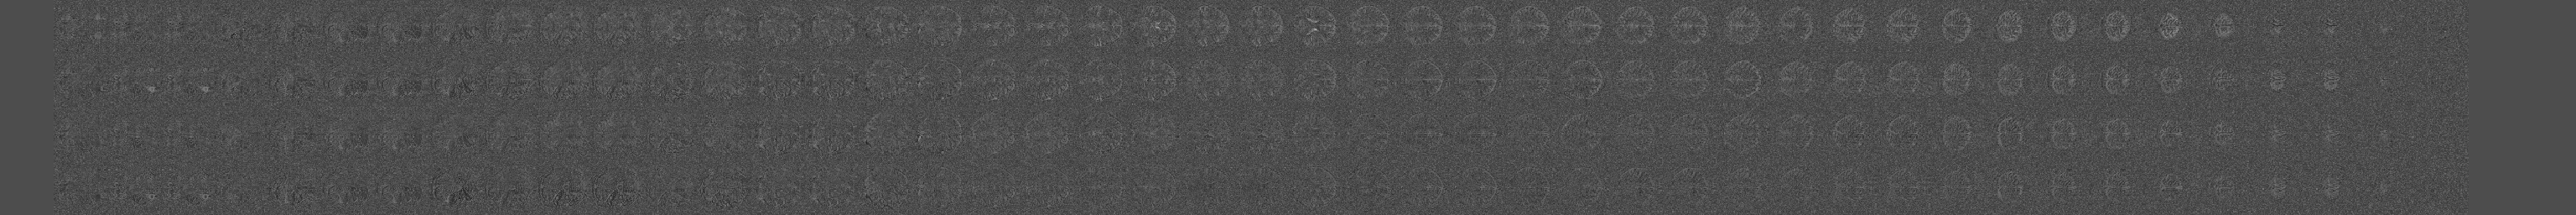

original func


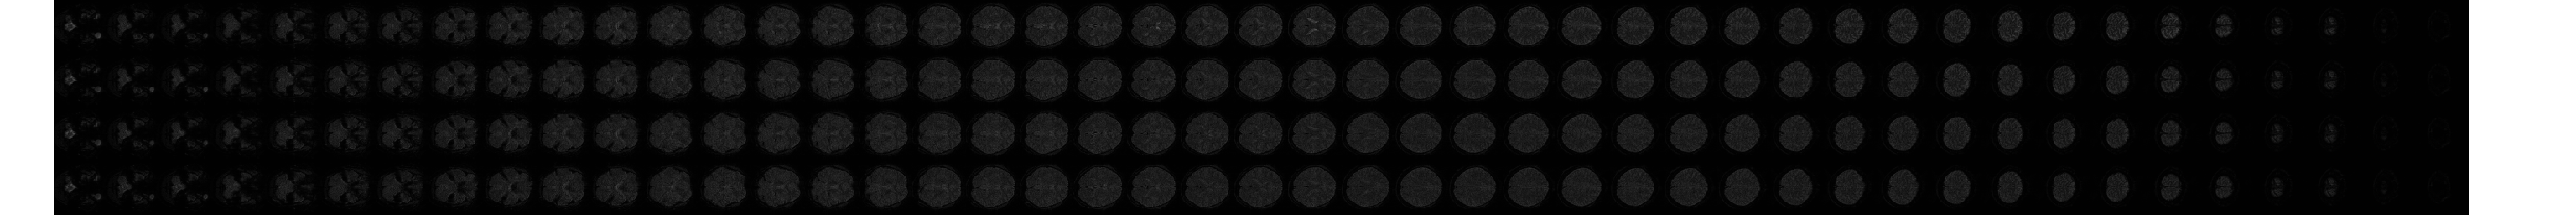


tube func without adding mean/sd references


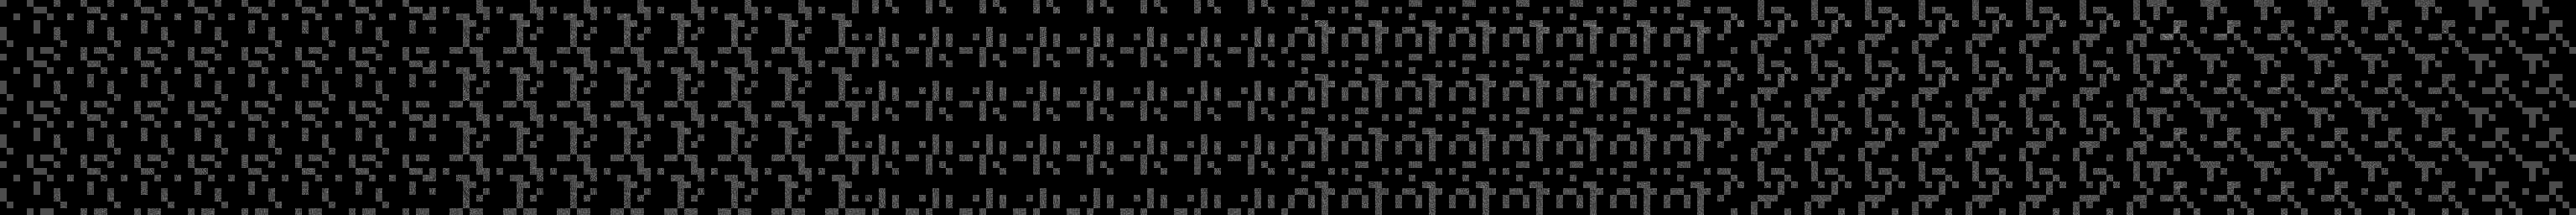

tube func


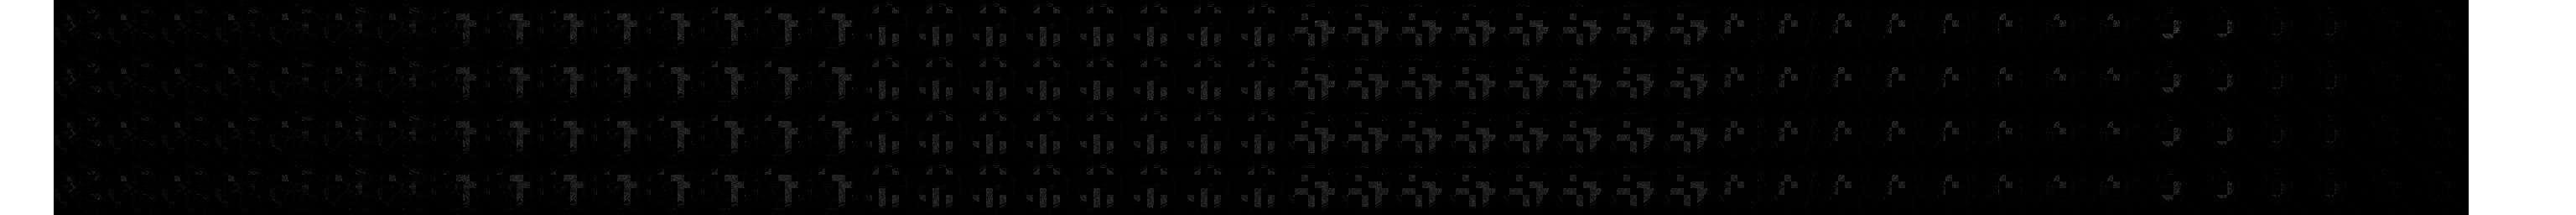


decoder func without adding mean/sd references


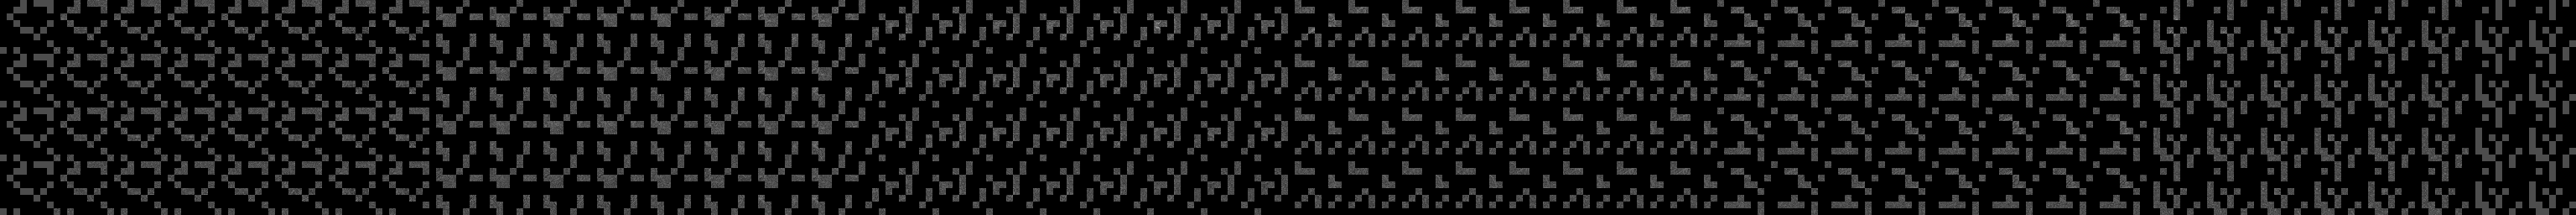

decoder func


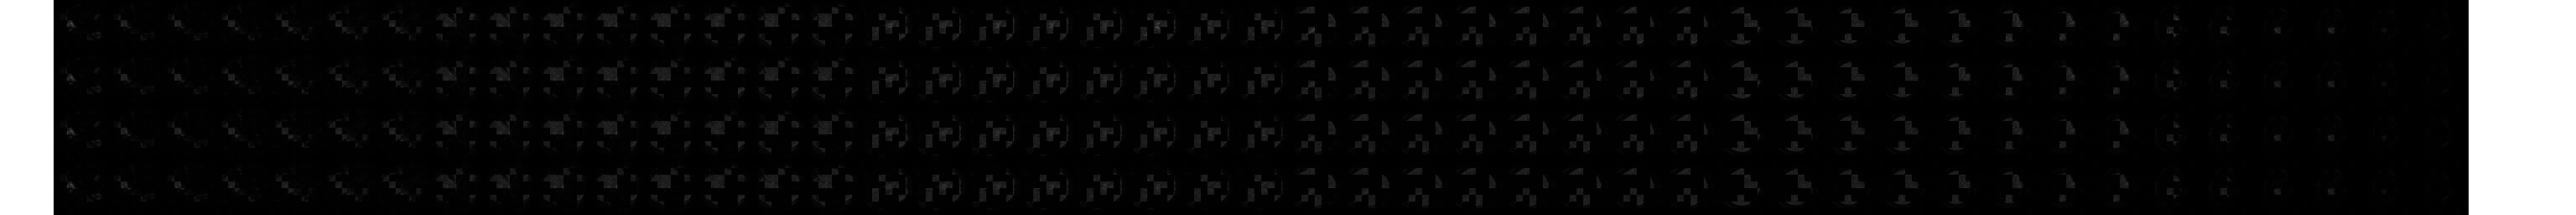

In [14]:
# extract func volumes and their reference mean and standard deviation volumes
func, meansd = out
func = func.unsqueeze(1) # add empty first dimension to serve as 1d channel dimension

# patchify func samples
print("func", func.shape)
patches = model.patchify(func)
print("patches", patches.shape)

# compress into ViT compatible inputs (bs x seq_len x emb_size)
patches_vit = rearrange(patches, 'b ... d -> b (...) d')
print("patches_vit", patches_vit.shape)
print("num patches in one timepoint", patches_vit.shape[1] // num_frames)

# create tube mask (i.e., a mask that is the same for all frames/timepoints)
assert num_patches == patches_vit.shape[1]
tube_mask = torch.zeros(num_patches//num_frames).to(torch.bool) # start by masking everything (aka include nothing)
mask_idx = torch.randperm(num_patches//num_frames)
tube_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
print("num tube patches =", len(mask_idx) - len(tube_mask_idx))
tube_mask[tube_mask_idx] = True # Trues mean to include the patch, False means to remove the patch
tube_mask = tube_mask.tile(num_frames) # repeat masking for the other timepoints
print("tube mask percent masked", tube_mask.sum() / len(tube_mask))

# create decoder mask similar to tube mask, but ensure no overlap
decoder_mask = torch.ones(num_patches//num_frames).to(torch.bool) # start by masking nothing (aka include everything)
remaining_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
decoder_mask_idx = remaining_mask_idx[:int(num_patches/num_frames*(1-decoder_mask_ratio))]
print("num decoder patches =", len(decoder_mask_idx))
decoder_mask[decoder_mask_idx] = False
decoder_mask = decoder_mask.tile(num_frames) # repeat masking for the other timepoints
print("decoder_mask percent masked", decoder_mask.sum() / len(decoder_mask))

# apply masks to patches_vit
tube_patches_vit = copy.deepcopy(patches_vit)
decoder_patches_vit = copy.deepcopy(patches_vit)
tube_patches_vit[:,tube_mask] = 0.
decoder_patches_vit[:,decoder_mask] = 0.

# undo patchification so we can visualize
tube_unpatches = rearrange(tube_patches_vit, 'b (f d h w) c -> b f d h w c', f=num_frames, d=patch_size, h=patch_size)
decoder_unpatches = rearrange(decoder_patches_vit, 'b (f d h w) c -> b f d h w c', f=num_frames, d=patch_size, h=patch_size)
print("tube_unpatches", tube_unpatches.shape)
print("decoder_unpatches", decoder_unpatches.shape)
tube_func = rearrange(tube_unpatches, 'b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)', 
                      b=len(func), f=num_frames, d=8, h=8, w=6,
                      pd=patch_size, ph=patch_size, pw=patch_size, pf=frame_patch_size)
decoder_func = rearrange(decoder_unpatches, 'b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)', 
                      b=len(func), f=num_frames, d=8, h=8, w=6,
                      pd=patch_size, ph=patch_size, pw=patch_size, pf=frame_patch_size)
print("tube_func", tube_func.shape)
print("decoder_func", decoder_func.shape)

idx = 0
mean, sd = meansd[idx]
print("original func without adding mean/sd references")
display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx])))
print("original func")
display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx] * mean + sd)))

print("\ntube func without adding mean/sd references")
display(transforms.ToPILImage()(utils.reshape_to_2d(tube_func[idx])))
print("tube func")
display(transforms.ToPILImage()(utils.reshape_to_2d(tube_func[idx] * mean + sd)))

print("\ndecoder func without adding mean/sd references")
display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx])))
print("decoder func")
display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx] * mean + sd)))

# Set up optimizer and begin model training

In [15]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

total_steps=num_epochs*num_iterations_per_epoch
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1, pct_start=2/num_epochs
)
        
print("\nDone with model preparations!")

total_steps 1890

Done with model preparations!


In [16]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()
model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

original volumes without adding mean/sd references


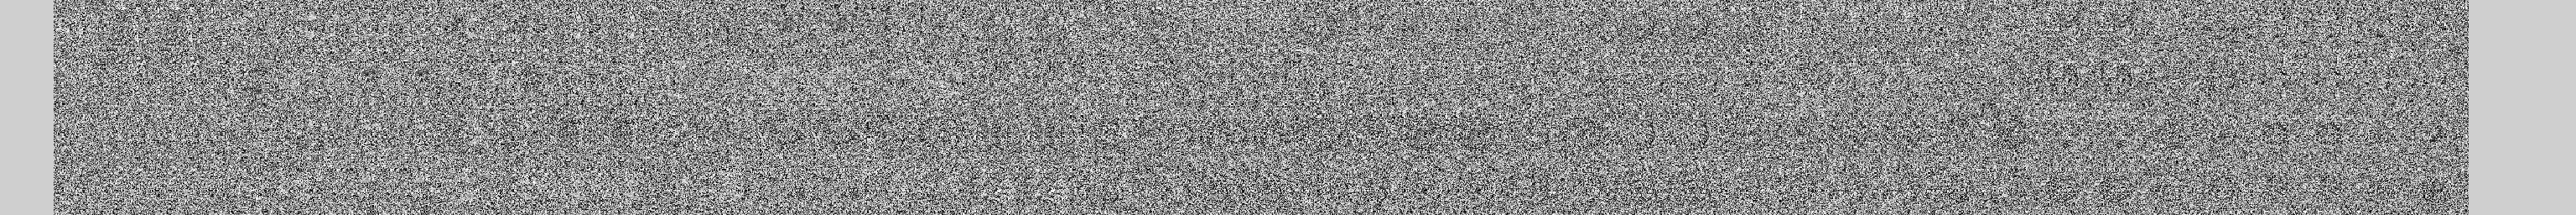

original volumes


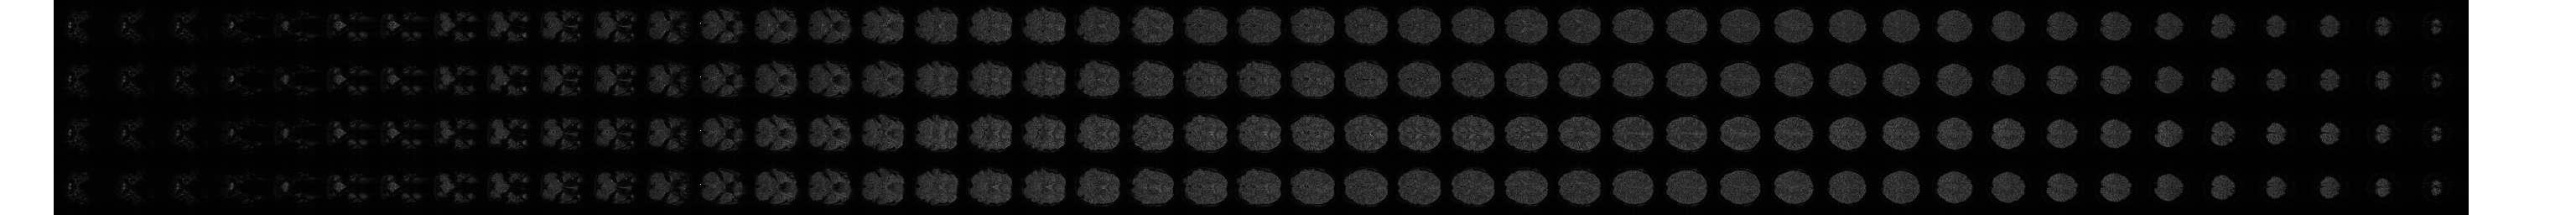

recons of decoded patches without adding mean/sd references


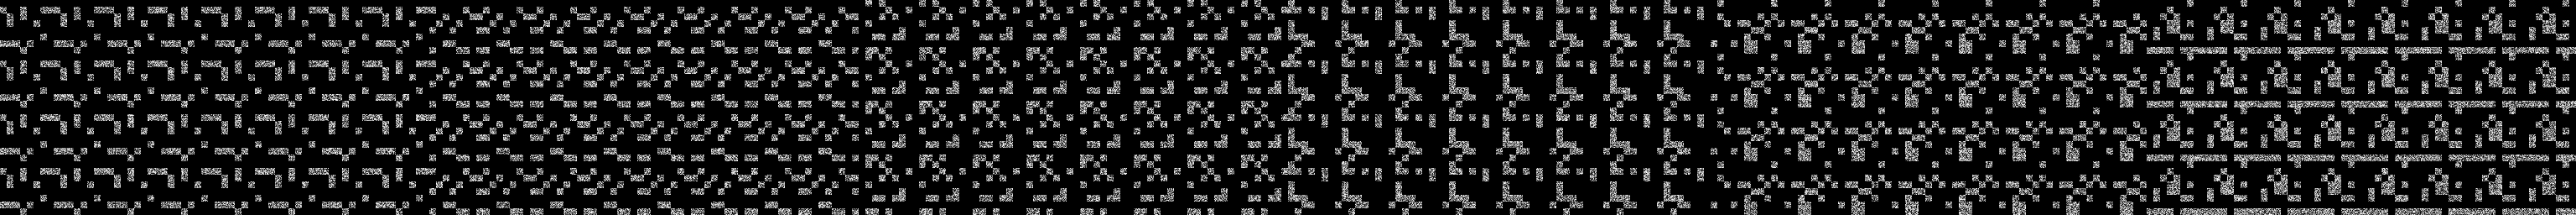

recons of decoded patches


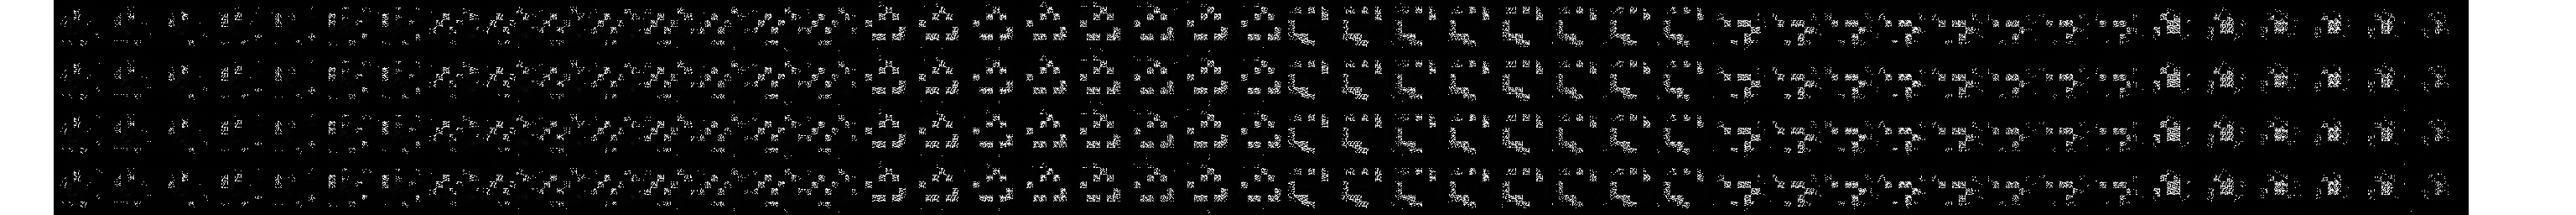

 17%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

recons of decoded patches without adding mean/sd references


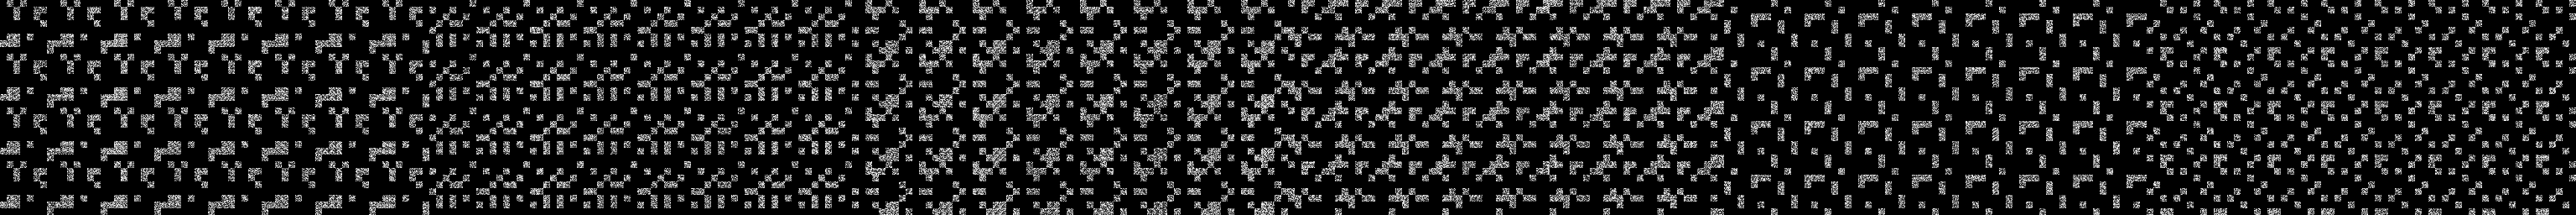

recons of decoded patches


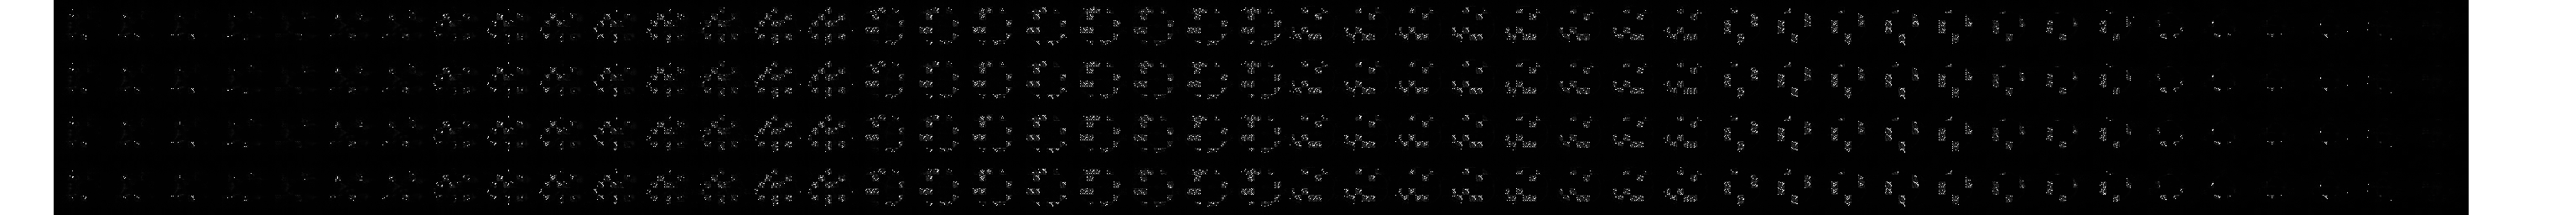

 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

recons of decoded patches without adding mean/sd references


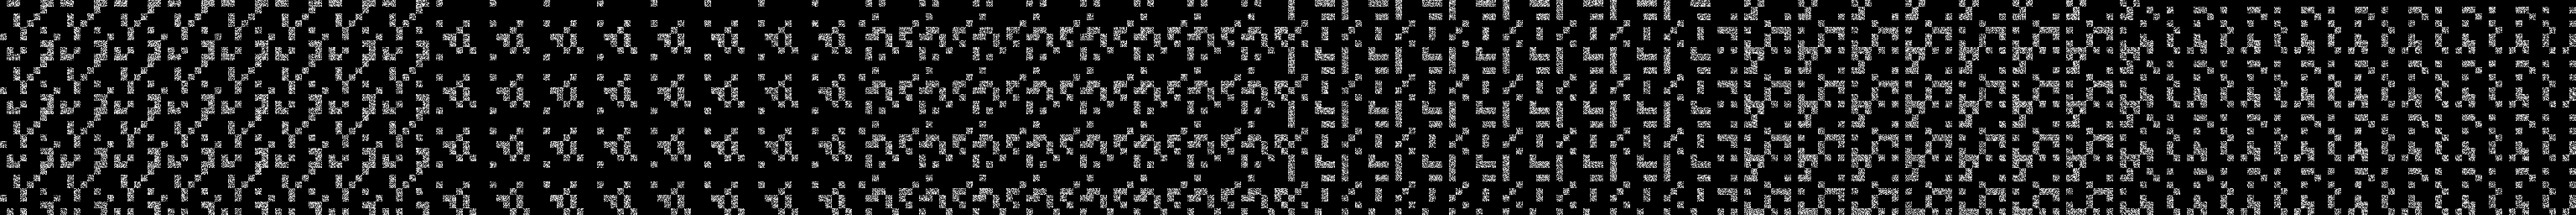

recons of decoded patches


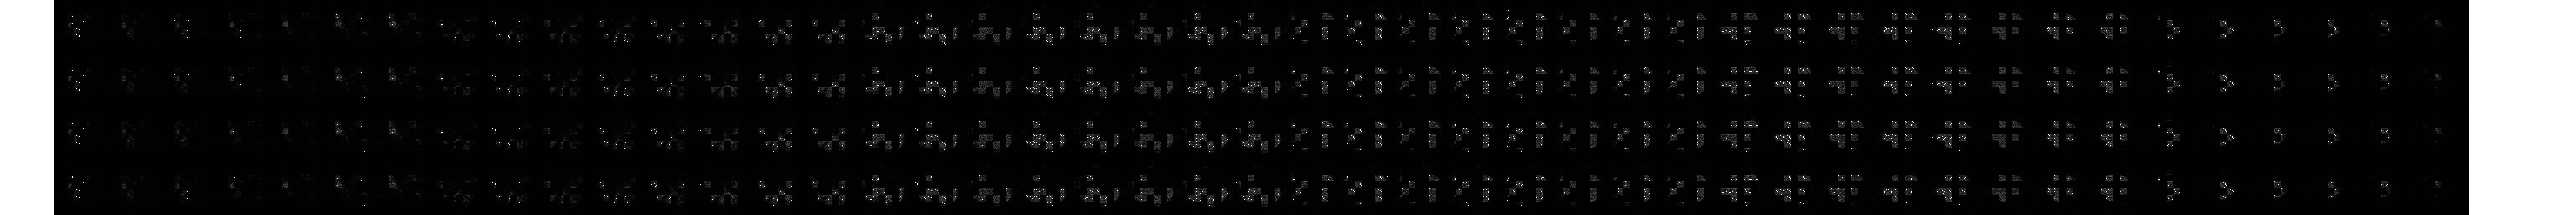

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                

recons of decoded patches without adding mean/sd references


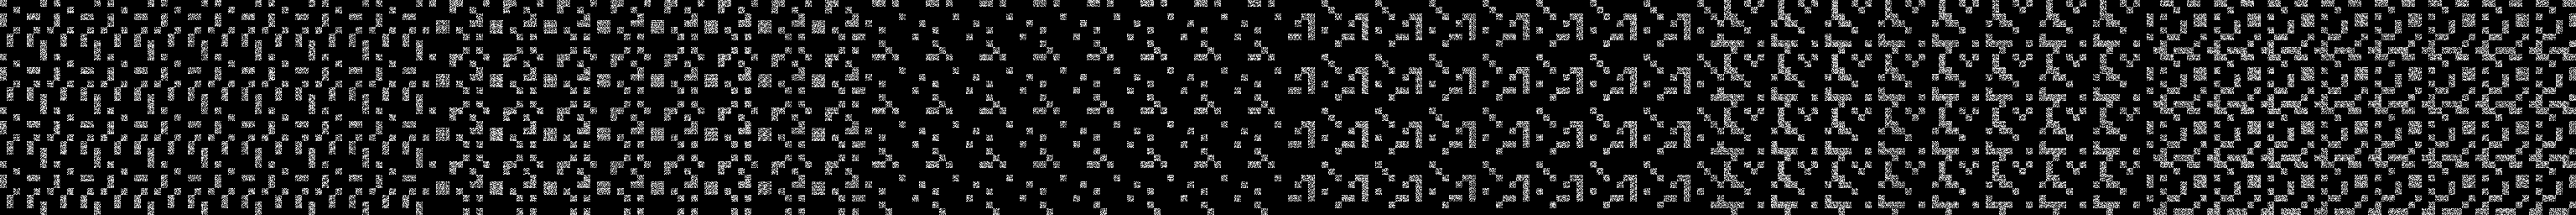

recons of decoded patches


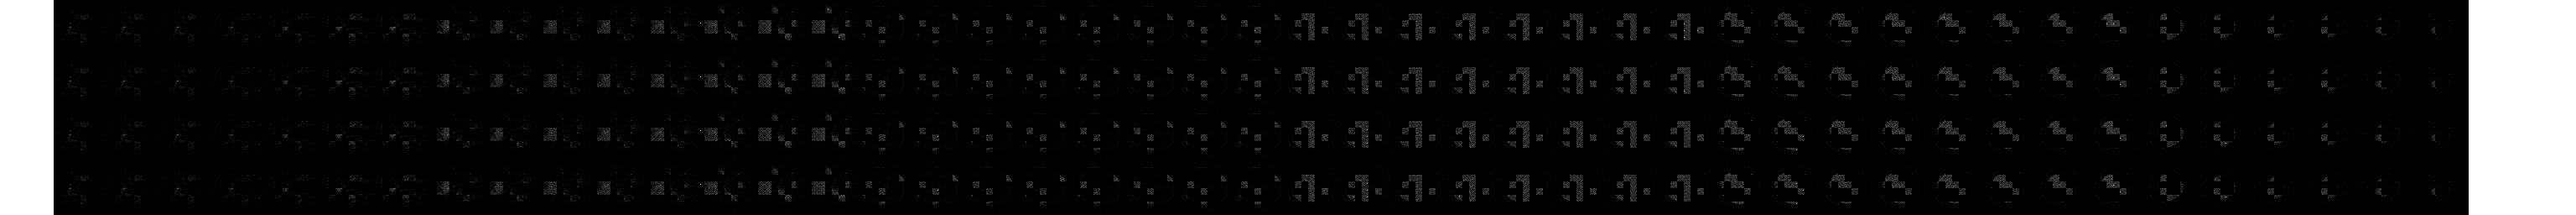

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                   

recons of decoded patches without adding mean/sd references


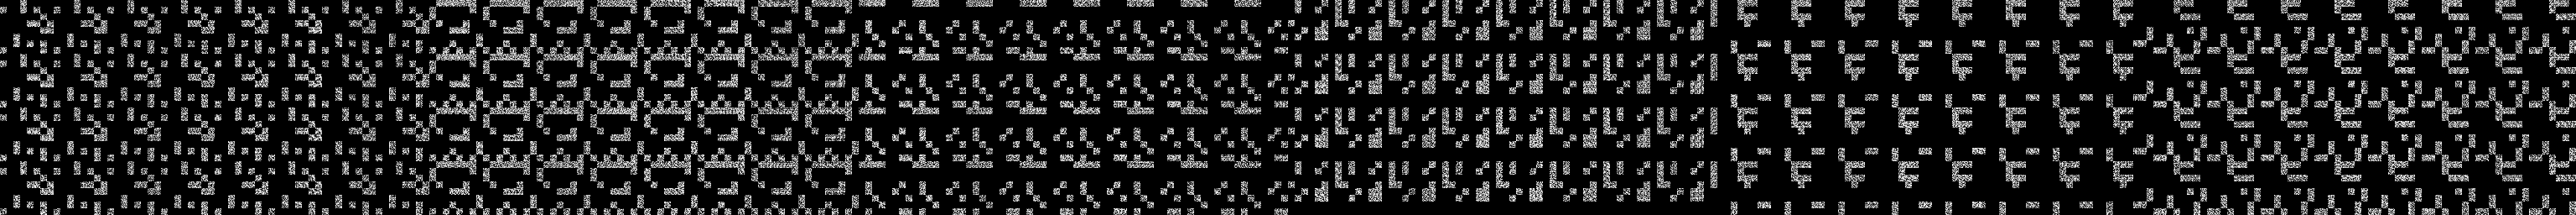

recons of decoded patches


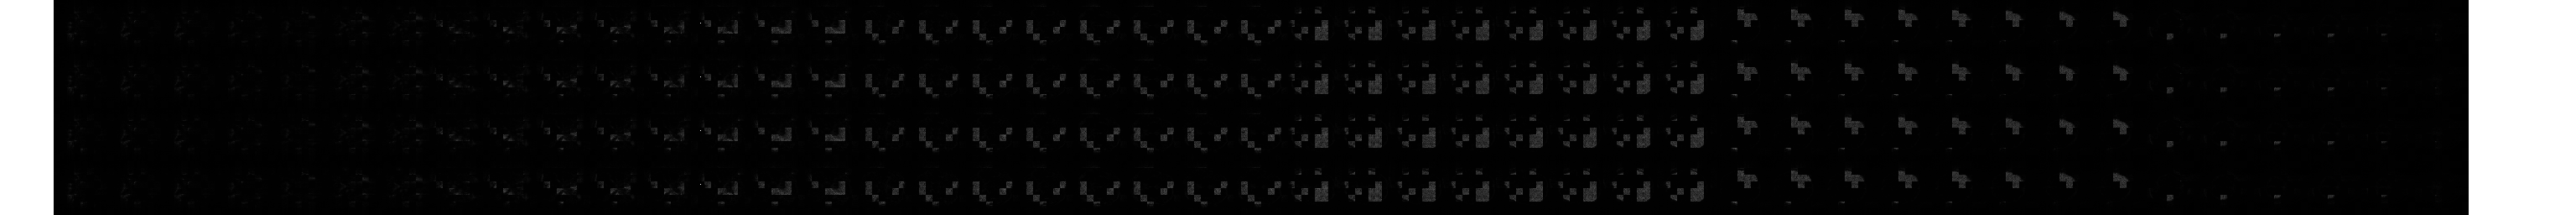

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         

recons of decoded patches without adding mean/sd references


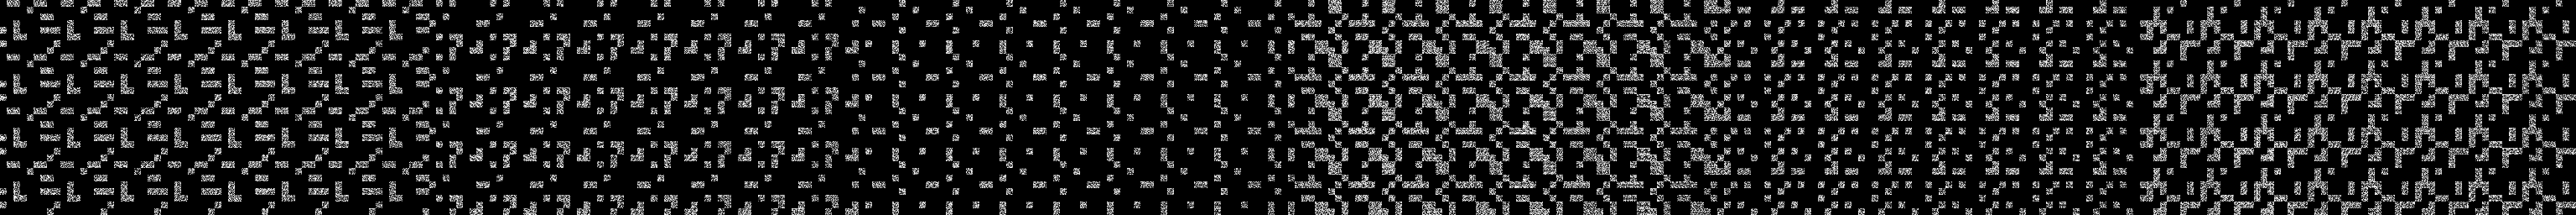

recons of decoded patches


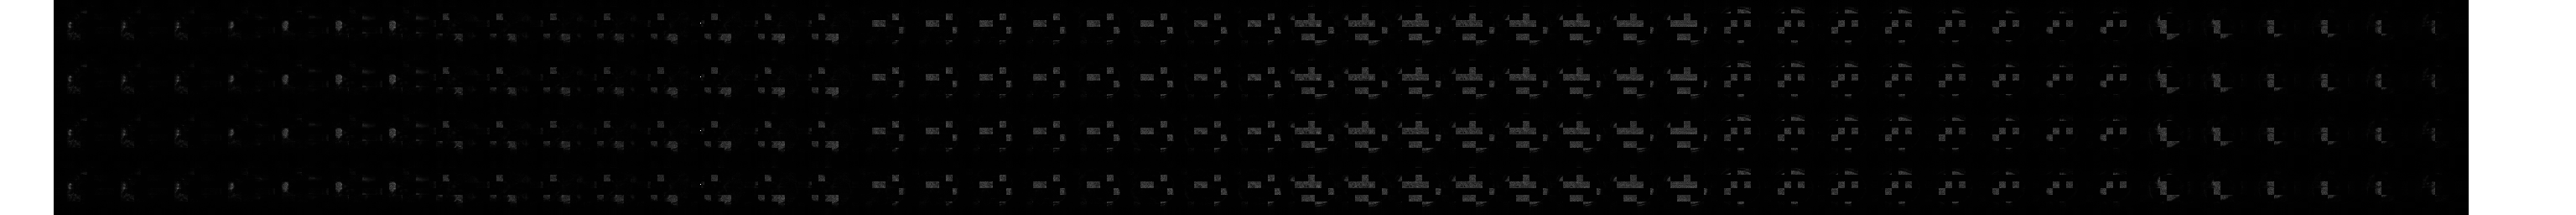

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [17]:
mse = nn.MSELoss()
lrs, losses, test_losses = [], [], []
recon_image_list = []
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
for epoch in progress_bar:
    with torch.cuda.amp.autocast(dtype=data_type):
        model.train()
        for train_i, batch in enumerate(train_dl): #total samples in 1 epoch = train_dl.nsamples
            optimizer.zero_grad()

            func, meansd = batch 
            func = func.unsqueeze(1).to(device)
            
            # create tube mask (i.e., a mask that is the same for all frames/timepoints)
            tube_mask = torch.zeros(num_patches//num_frames).to(torch.bool) # start by masking everything (aka include nothing)
            mask_idx = torch.randperm(num_patches//num_frames)
            tube_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
            tube_mask[tube_mask_idx] = True # Trues mean to include the patch, False means to remove the patch
            tube_mask = tube_mask.tile(num_frames) # repeat masking for the other timepoints
            
            # create decoder mask
            decoder_mask = torch.ones(num_patches//num_frames).to(torch.bool) # start by masking nothing (aka include everything)
            remaining_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
            decoder_mask_idx = remaining_mask_idx[:int(num_patches/num_frames*(1-decoder_mask_ratio))]
            decoder_mask[decoder_mask_idx] = False
            decoder_mask = decoder_mask.tile(num_frames) # repeat masking for the other timepoints
            
            # encode the tube patches
            encoder_out = model(func, encoder_mask=tube_mask)
            
            # decode both the encoder_out patches and masked decoder patches
            decoder_out = model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            # subset only the reconstructed decoder patches
            output = decoder_out[:,-num_decoder_patches:] 
            
            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, 'b ... d -> b (...) d')
            target = target_patches_vit[:,~decoder_mask]
            loss = mse(output, target)

            accelerator.backward(loss)
            optimizer.step()
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

        model.eval()
        for test_i, batch in enumerate(test_dl): 
            func, meansd = batch 
            func = func.unsqueeze(1).to(device)
            
            # create tube mask (i.e., a mask that is the same for all frames/timepoints)
            tube_mask = torch.zeros(num_patches//num_frames).to(torch.bool) # start by masking everything (aka include nothing)
            mask_idx = torch.randperm(num_patches//num_frames)
            tube_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
            tube_mask[tube_mask_idx] = True # Trues mean to include the patch, False means to remove the patch
            tube_mask = tube_mask.tile(num_frames) # repeat masking for the other timepoints
            
            # create decoder mask
            decoder_mask = torch.ones(num_patches//num_frames).to(torch.bool) # start by masking nothing (aka include everything)
            remaining_mask_idx = mask_idx[:int(num_patches/num_frames*tube_mask_ratio)]
            decoder_mask_idx = remaining_mask_idx[:int(num_patches/num_frames*(1-decoder_mask_ratio))]
            decoder_mask[decoder_mask_idx] = False
            decoder_mask = decoder_mask.tile(num_frames) # repeat masking for the other timepoints
            
            # encode the tube patches
            encoder_out = model(func, encoder_mask=tube_mask)
            
            # decode both the encoder_out patches and masked decoder patches
            decoder_out = model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            # subset only the reconstructed decoder patches
            output = decoder_out[:,-num_decoder_patches:] 
            
            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, 'b ... d -> b (...) d')
            target = target_patches_vit[:,~decoder_mask]
            loss = mse(output, target)
            
            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, 'b ... d -> b (...) d')
            target = target_patches_vit[:,~decoder_mask]
            loss = mse(output, target)
            test_losses.append(loss.item())

        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
               "test/loss": np.mean(test_losses[-(test_i+1):])}
        progress_bar.set_postfix(**logs)
        
        # Plot progress (first sample in batch)
        with torch.no_grad():
            # prep reference volumes for going back to original data
            idx = 0
            mean, sd = meansd[idx]
            mean, sd = mean.to(device), sd.to(device)
            if epoch == 0:
                print("original volumes without adding mean/sd references")
                display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx])*5)) # scaling by 5 for visualization contrast
                print("original volumes")
                display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx] * mean + sd)))
            if epoch % 5 == 0:
                # undo patchification so we can visualize
                decode_vis = torch.zeros_like(target_patches_vit)
                decode_vis[:,~decoder_mask] = output
                decoder_unpatches = rearrange(decode_vis, 'b (f d h w) c -> b f d h w c', f=num_frames, d=patch_size, h=patch_size)
                decoder_func = rearrange(decoder_unpatches, 'b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)', 
                                      b=batch_size, f=num_frames, d=8, h=8, w=6,
                                      pd=patch_size, ph=patch_size, pw=patch_size, pf=frame_patch_size)
                print("recons of decoded patches without adding mean/sd references")
                display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx]*5))) # scaling by 5 for visualization contrast
                print("recons of decoded patches")
                display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx] * mean + sd)))

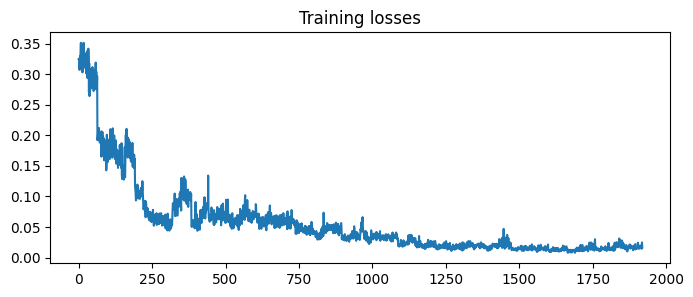

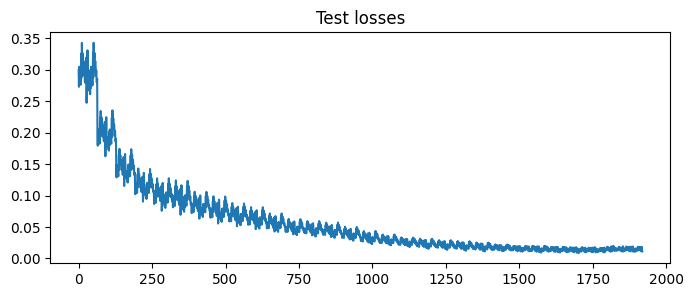

In [18]:
plt.figure(figsize=(8,3))
plt.plot(losses)
plt.title("Training losses")
plt.show()
plt.figure(figsize=(8,3))
plt.plot(test_losses)
plt.title("Test losses")
plt.show()

In [22]:
# save model ckpt
torch.save({'model_state_dict': model.state_dict()}, "last.ckpt")